In [ ]:
import kagglehub
import os
import glob

# Download latest version of the public dataset
path = kagglehub.dataset_download("alexteboul/english-premier-league-logo-detection-20k-images")

print("Path to dataset files:", path)

# Define the base directory for logos (adjusted for nested epl-logos-big)
epl_logos_dir = os.path.join(path, "epl-logos-big", "epl-logos-big")
print(f'Location of the dataset: {epl_logos_dir}')
# Check if the epl-logos-big/epl-logos-big directory exists
if not os.path.exists(epl_logos_dir):
    print(f"Error: Directory {epl_logos_dir} not found.")
    print("Contents of dataset root:", os.listdir(path))
    print("Contents of epl-logos-big:", os.listdir(os.path.join(path, "epl-logos-big")))
    raise FileNotFoundError("epl-logos-big/epl-logos-big directory not found.")

# Print contents of epl-logos-big/epl-logos-big for debugging
print("Contents of epl-logos-big/epl-logos-big:", os.listdir(epl_logos_dir))

# Get list of club directories
club_dirs = [d for d in os.listdir(epl_logos_dir) if os.path.isdir(os.path.join(epl_logos_dir, d))]
if not club_dirs:
    print(f"Error: No club directories found in {epl_logos_dir}.")
    raise FileNotFoundError("No club directories found.")

# Dictionary to store image paths per club
global club_image_paths
club_image_paths = {}

# Iterate through each club directory and find image files
for club in club_dirs:
    club_path = os.path.join(epl_logos_dir, club)
    # Find all image files (.png and .jpg)
    image_files = glob.glob(os.path.join(club_path, "*.png")) + glob.glob(os.path.join(club_path, "*.jpg"))
    if image_files:
        club_image_paths[club] = image_files
    else:
        print(f"Warning: No .png or .jpg images found in {club_path}")
        print(f"Contents of {club} directory:", os.listdir(club_path))

print("Found clubs:", list(club_image_paths.keys()))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Check if club_image_paths exists (from Cell 1)
try:
    if not club_image_paths:
        raise NameError("club_image_paths is empty or not defined.")
except NameError:
    print("Error: club_image_paths not found. Please run Cell 1 first.")
    raise

# Set up the plot
num_clubs = len(club_image_paths)
cols = 3  # Number of columns for the grid
rows = (num_clubs + cols - 1) // cols  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()  # Flatten for easy iteration

# Iterate through clubs and display one random image
for idx, (club, image_paths) in enumerate(club_image_paths.items()):
    if image_paths:  # Ensure there are images for the club
        # Select a random image
        img_path = random.choice(image_paths)
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(club)
            axes[idx].axis("off")
            print(f"Displaying {club} image: {img_path} ({img.size[0]}x{img.size[1]} pixels)")
        except Exception as e:
            print(f"Error displaying image for {club}: {e}")
            axes[idx].set_title(f"{club} (Error)")
            axes[idx].axis("off")
    else:
        axes[idx].set_title(f"{club} (No images)")
        axes[idx].axis("off")

# Hide empty subplots
for idx in range(len(club_image_paths), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Set seed for reproducibility
torch.manual_seed(1234)

# Define dataset path
base_dir = epl_logos_dir

# === Full Preprocessing: ===  #
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # Geometric transformations
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    # Color and intensity transformations
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    # Crop to final size
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    # Occlusion
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    # Normalization 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Random operation
])


# Load dataset WITH normalization
dataset = datasets.ImageFolder(
    root=base_dir,
    transform=transform
)

In [9]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size #AKA remaining 15% :)

print(f"Total Size: {total_size} \nTrain Size: {train_size} \nValidation Size: {val_size} \nTest size: {test_size}")

Total Size: 20000 
Train Size: 14000 
Validation Size: 3000 
Test size: 3000


In [10]:
#splitting the data 
train_dataset, val_dataset, test_dataset = random_split(dataset,[train_size,val_size,test_size])

#dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size = 32, 
    shuffle=True,
    num_workers = 2, 
    pin_memory = True)

val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

#Inspection time (HAHAHAHAHAHAHAHAHAHAHA)
images,labels = next(iter(train_loader))
print(f"Train batch shape:{images.shape}, Labels: {labels[:5]}")

images,labels = next(iter(val_loader))
print(f"validation batch shape: {images.shape}, Labels: {labels[:5]}")

images,labels = next(iter(test_loader))
print(f"Test batch shape: {images.shape}, Labels: {labels[:5]}")

Train batch shape:torch.Size([32, 3, 224, 224]), Labels: tensor([ 9, 17, 14, 17,  1])
validation batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([11,  0,  0, 16,  4])
Test batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([ 0,  5, 11, 14, 16])


In [12]:
import torch.nn as nn

model = nn.Sequential(
    # Conv1: 3 input channels (RGB) → 32 output channels, 3x3 kernel, padding=1
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: 224x224x32
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 112x112x32
    # Conv2: 32 input channels → 64 output channels
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 112x112x64
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 56x56x64
    # Conv3: 64 input channels → 128 output channels
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 56x56x128
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 28x28x128
    # Flatten
    nn.Flatten(),                                          # Output: 28x28x128 = 100352
    # Dense layers
    nn.Linear(100352, 128),                                # Output: 128
    nn.ReLU(),
    nn.Dropout(0.5),                                       # Prevent overfitting
    nn.Linear(128, len(dataset.classes))                   # Output: 20 classes
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device used to train: {device}")

# Inspect model
print(model)

# Test with one batch
images, labels = next(iter(train_loader))
images = images.to(device)
outputs = model(images)
print(f"Output shape: {outputs.shape}")

Device used to train: cuda
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=100352, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=128, out_features=20, bias=True)
)
Output shape: torch.Size([32, 20])


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [15]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images,labels in train_loader:
        images,labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _,predicted = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (predicted ==labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images,labels in val_loader:
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            _,predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/15, Train Loss: 1.8594, Train Acc: 42.13%, Val Loss: 1.0362, Val Acc: 68.50%
Epoch 2/15, Train Loss: 0.9924, Train Acc: 68.38%, Val Loss: 0.5102, Val Acc: 85.17%
Epoch 3/15, Train Loss: 0.7047, Train Acc: 78.17%, Val Loss: 0.3784, Val Acc: 88.57%
Epoch 4/15, Train Loss: 0.5646, Train Acc: 82.27%, Val Loss: 0.2855, Val Acc: 91.30%
Epoch 5/15, Train Loss: 0.4864, Train Acc: 84.61%, Val Loss: 0.3142, Val Acc: 90.80%
Epoch 6/15, Train Loss: 0.3982, Train Acc: 87.64%, Val Loss: 0.2111, Val Acc: 93.87%
Epoch 7/15, Train Loss: 0.3811, Train Acc: 88.33%, Val Loss: 0.1724, Val Acc: 95.43%
Epoch 8/15, Train Loss: 0.3623, Train Acc: 89.14%, Val Loss: 0.1908, Val Acc: 93.87%
Epoch 9/15, Train Loss: 0.3223, Train Acc: 89.98%, Val Loss: 0.1693, Val Acc: 94.57%
Epoch 10/15, Train Loss: 0.3094, Train Acc: 90.54%, Val Loss: 0.1414, Val Acc: 95.70%
Epoch 11/15, Train Loss: 0.2670, Train Acc: 91.79%, Val Loss: 0.1359, Val Acc: 96.47%
Epoch 12/15, Train Loss: 0.2622, Train Acc: 91.99%, Val Loss: 0

In [16]:
# Test phase (after training)
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.1042, Test Accuracy: 96.47%


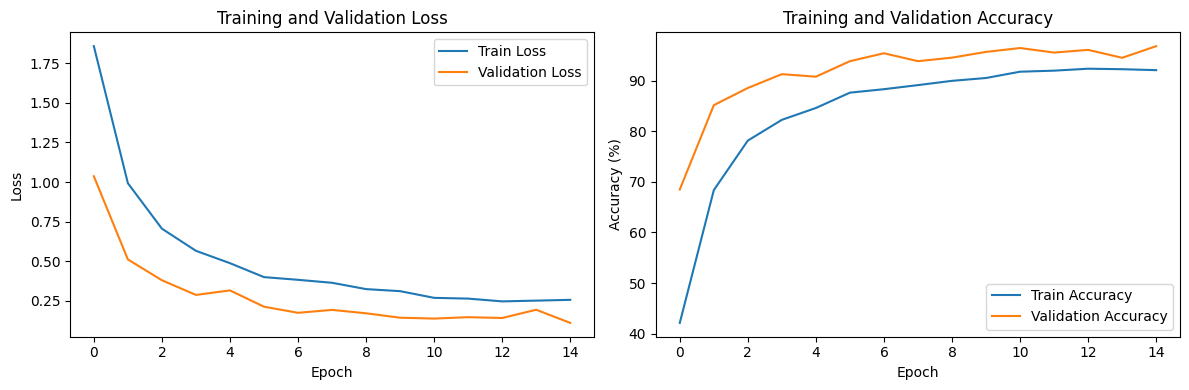

In [17]:
# Plotting training progress
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()